# 発表資料などの資料作成に必要な素材を生成するためのノート


In [1]:
# summarized_ = return_summarized_Fixed_dataframe()
# print(summarized_)
# indices = summarized_.index.values
# columns = summarized_.columns.values
# print(indices)
# print(columns)

# plt.figure()
# for row in indices:
#     print(summarized_.loc[row].to_numpy())
#     plt.plot(columns, summarized_.loc[row].to_numpy())

# return_summarized_Fixed_dataframe(BenchMark_name="cg").to_csv("./tmp_GenerateResources/SummarizedFixedDataframe_cg.csv")

# path = "./tmp_GenerateResources/"

# def generateScoreTable(benchmark_name="cg"):
#     list_ScoreTable = []
#     dict_summary_fixed_class = return_dict_summary_fixed(benchmark_name=benchmark_name, fixed="class")
#     raw_x = dict_summary_fixed_class["processes"]
# #     print(f"raw_x : {raw_x}, benchmark : {benchmark_name}")
#     for content in dict_summary_fixed_class:
#         if(content == "processes"):
#             continue
#         raw_y = dict_summary_fixed_class[content]
#         if(does_include_nan(raw_y)):
#             continue
# #         print(f"raw_y(={content}) : {raw_y}")
#         # 線形モデル
#         model_lin = ModelLin(raw_x, raw_y, benchmark_name, content)
#         model_lin.calc_lr()
#         model_lin.calc_r2_score()
#         model_lin.calc_mae_score()
#         model_lin.calc_mse_score()
#         model_lin.calc_rmse_score()
#         model_lin.calc_mape_score()
#         model_lin.plot_graph()
#         plt.title(f"ベンチマーク名：{model_lin.benchmark_name}, 関数名：{model_lin.function_name}, MAPE : {model_lin.mape_score}", y=-0.2)
#         plt.show()
#         # logモデル
#         model_log10 = ModelLog10(raw_x, raw_y, benchmark_name, content)
#         model_log10.calc_lr()
#         model_log10.calc_r2_score()
#         model_log10.calc_mae_score()
#         model_log10.calc_mse_score()
#         model_log10.calc_rmse_score()
#         model_log10.calc_mape_score()
#         model_log10.plot_graph()
#         if(model_log10.benchmark_name == "cg" and model_log10.function_name == "MPI_Irecv()"):
#             plt.savefig(path+model_log10.benchmark_name+'_'+model_log10.function_name+'.pdf')
#         if(model_log10.benchmark_name == "cg" and model_log10.function_name == "ICNVRT"):
#             plt.savefig(path+model_log10.benchmark_name+'_'+model_log10.function_name+'.pdf')
#         plt.title(f"ベンチマーク名：{model_log10.benchmark_name}, 関数名：{model_log10.function_name}, MAPE : {model_log10.mape_score}", y=-0.2)
#         plt.show()
#         # 反比例モデル
#         model_ip = ModelIP(raw_x, raw_y, benchmark_name, content)
#         model_ip.calc_lr()
#         model_ip.calc_r2_score()
#         model_ip.calc_mae_score()
#         model_ip.calc_mse_score()
#         model_ip.calc_rmse_score()
#         model_ip.calc_mape_score()
#         model_ip.plot_graph()
#         if(model_log10.benchmark_name == "lu" and model_log10.function_name == "EXACT"):
#             plt.savefig(path+model_log10.benchmark_name+'_'+model_log10.function_name+'.pdf')
#         plt.title(f"ベンチマーク名：{model_ip.benchmark_name}, 関数名：{model_ip.function_name}, MAPE : {model_ip.mape_score}", y=-0.2)
#         plt.show()
#         list_ScoreTable.append([content, model_lin.mape_score, model_log10.mape_score, model_ip.mape_score])
#     df_ScoreTable = pd.DataFrame(list_ScoreTable)
#     df_ScoreTable.columns = ["", "x mape", "logx mape", "1/x mape"]
#     df_ScoreTable.set_index("",inplace=True)
#     df_ScoreTable

# for benchmark in benchmarks:
#     generateScoreTable(benchmark)

# # 資料作成に使用する最もフィットするモデルはどれかを示すための表・グラフを作るためのプログラム


# def return_list_of_ratio_row(input_list):
#     sum_of_input_list = 0
#     return_list = []
#     for list_child in input_list:
#         sum_of_input_list += len(list_child)
#     for list_child in input_list:
#         num = int(len(list_child)/sum_of_input_list*10000)/100
#         return_list.append(num)
#     # 総和を100にする処理
#     # 最大になることの多い線形モデルはほかのモデルの割合の総和を100から引いたものにしている
#     i_0 = 100
#     for i in range(1, len(input_list)):
#         i_0 -= return_list[i]
#     return_list[0] = i_0
#     return(return_list)

# def return_list_of_range_row(input_list):
#     return_list = []
#     for list_child in input_list:
#         if(len(list_child) == 0):
#             data_str = "(NoData)"
#         else:
#             min_data = int(min(list_child)*100)/100
#             max_data = int(max(list_child)*100)/100
#             data_str = f"({min_data}-{max_data})"
#         return_list.append(data_str)
#     return(return_list)


# def return_row_list(input_list):
#     return_list = []
#     # 割合の入ったリストと最小・最大値の入ったリスト
#     list_of_ratio_row = return_list_of_ratio_row(input_list)
#     list_of_range_row = return_list_of_range_row(input_list)
    
#     # 上の二つのリストの要素同士を結合させる
#     for i in range(len(list_of_ratio_row)):
#         return_list.append(f"{list_of_ratio_row[i]}%{list_of_range_row[i]}")
    
#     return return_list

# csv_directory_path = './tmp_GenerateResources/'

# result_of_all = [[], [], []]
# list_for_csv = []

# list_for_csv_ratio = []
# list_for_csv_range = []

# for benchmark in benchmarks:
#     result_of_benchmark = [[], [], []]
#     file_name = benchmark+'.csv'
#     file_path = csv_directory_path+file_name
#     # ファイルが存在しない場合は処理を飛ばす
#     if(os.path.isfile(csv_directory_path+file_name) == False):
#         continue
#     # 完全に値をとれたもののみで集計するようにしている
#     if(benchmark != "cg" and benchmark != "ep" and benchmark != "lu"):
#         continue
#     # 現在処理中のベンチマーク名を出力
#     print(benchmark)
#     df = pd.read_csv(file_path, index_col=0)
#     columns = df.columns.values
#     indices = df.index.values
#     for index in indices:
#         row = df.loc[index].tolist()
#         result_of_benchmark[row.index(min(row))].append(min(row))
#         result_of_all[row.index(min(row))].append(min(row))
#     list_for_csv.append([benchmark]+return_row_list(result_of_benchmark))
# list_for_csv.append(["all"]+return_row_list(result_of_all))

# print(list_for_csv)

# csv_head = ["", "線形モデル", "対数モデル", "反比例モデル"]
# df_for_csv = pd.DataFrame(list_for_csv)
# df_for_csv.columns = csv_head
# df_for_csv.set_index("")
# df_for_csv

# # ipynb形式のライブラリのインポート
# %run ./lib.ipynb

# for benchmark in benchmarks:
#     SummarizedDF= return_summarized_Fixed_dataframe(BenchMark_name =benchmark, fixed="class")
#     SummarizedDFIndex = SummarizedDF.index.tolist()
#     SummarizedDFColumns = SummarizedDF.columns.tolist()
#     x_list = SummarizedDFColumns
#     targetFunctions=["RHS", "CFFTZ", "ICNVRT", "BUBBLE"]
#     for FunctionNames in SummarizedDFIndex:
#         y_list = SummarizedDF.loc[FunctionNames].tolist()
#         if(FunctionNames in targetFunctions and (does_include_nan(y_list))==False):
#             print(f"{FunctionNames}@{benchmark}")
#             plt.figure()
#             plt.title(FunctionNames)
#             plt.plot(x_list,y_list)
#             plt.xlabel('プロセス数')
#             plt.ylabel('コール回数')
#             plt.show()
#             if(FunctionNames=="RHS"):
#                 modelLin = ModelLin(raw_x=x_list, raw_y=y_list, benchmark_name=benchmark, function_name=FunctionNames)
#                 modelLin.train_x = modelLin.raw_x
#                 modelLin.train_y = modelLin.raw_y
#                 modelLin.calc_lr()
#                 modelLin.plot_graph(save=True, fileName=f"./tmp_GenerateResources/{FunctionNames}@{benchmark}.pdf")
#             elif(FunctionNames=="BUBBLE"):
#                 modelLog10 = ModelLog10(raw_x=x_list, raw_y=y_list, benchmark_name=benchmark, function_name=FunctionNames)
#                 modelLog10.train_x = modelLog10.raw_x
#                 modelLog10.train_y = modelLog10.raw_y
#                 modelLog10.calc_lr()
#                 modelLog10.plot_graph(save=True, fileName=f"./tmp_GenerateResources/{FunctionNames}@{benchmark}.pdf")
#             elif(FunctionNames=="CFFTZ"):
#                 modelIP = ModelIP(raw_x=x_list, raw_y=y_list, benchmark_name=benchmark, function_name=FunctionNames)
#                 modelIP.train_x = modelIP.raw_x
#                 modelIP.train_y = modelIP.raw_y
#                 modelIP.calc_lr()
#                 modelIP.plot_graph(save=True, fileName=f"./tmp_GenerateResources/{FunctionNames}@{benchmark}.pdf")
#             elif(FunctionNames=="ICNVRT"):
#                 modelBranch = ModelBranch(raw_x=x_list, raw_y=y_list, benchmark_name=benchmark, function_name=FunctionNames)
#                 modelBranch.train_x = modelBranch.raw_x
#                 modelBranch.train_y = modelBranch.raw_y
#                 modelBranch.calc_lr()
#                 modelBranch.plot_graph(save=True, fileName=f"./tmp_GenerateResources/{FunctionNames}@{benchmark}.pdf")

/Users/user/.yenv/versions/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


↓プロセス数を固定したもの
↓ベンチマーククラスを固定したもの


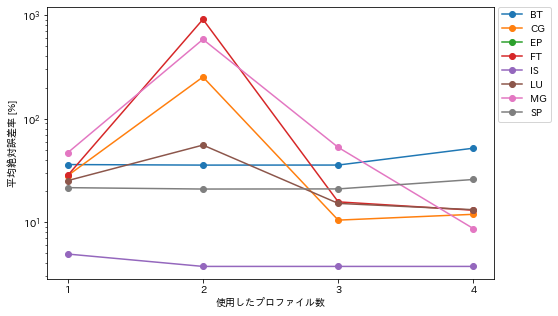

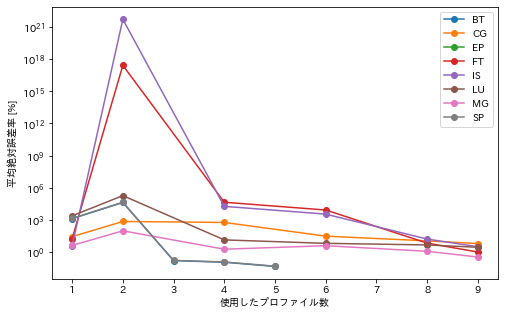

In [2]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

# 論文で必要なグラフを生成する1
print("↓プロセス数を固定したもの")
GenGraphAveragePerProfileNum(benchmarks=benchmarks, Fixed="Process", Fix=64, Predict="D", EnableTitle=False, SaveGraph=True)
print("↓ベンチマーククラスを固定したもの")
GenGraphAveragePerProfileNum(benchmarks=benchmarks, Fixed="Class", Fix="B", Predict=256, EnableTitle=False, SaveGraph=True)

In [3]:
# # 論文で必要なグラフを生成する2
# for benchmark in benchmarks:
#     print(benchmark)
#     print("↓プロセス数を固定したもの")
#     GenGraphTotalTimePerProfileNum(benchmark=benchmark, Fixed="Process", Fix=64, Predict="D", EnableTitle=False, SaveGraph=True)
#     print("↓ベンチマーククラスを固定したもの")
#     GenGraphTotalTimePerProfileNum(benchmark=benchmark, Fixed="Class", Fix="B", Predict=256, EnableTitle=False, SaveGraph=True)
    

# # 論文で必要なグラフを生成する3
# benchmarks01 = ['cg', 'ep', 'mg']
# benchmarks02 = ['ft', 'lu']
# benchmarks03 = ["bt", "sp"]
# benchmarks04 = ['is']
# print(f"benchmarks01 = {benchmarks01}, benchmarks02 = {benchmarks02}, benchmarks03 = {benchmarks03}")
# print(f"↓ベンチマーククラスを固定したもの@{benchmarks01}")
# GenGraphAveragePerProfileNum(benchmarks=benchmarks01, Fixed="Class", Fix="B", Predict=256, EnableTitle=True)
# print(f"↓ベンチマーククラスを固定したもの@{benchmarks02}")
# GenGraphAveragePerProfileNum(benchmarks=benchmarks02, Fixed="Class", Fix="B", Predict=256, EnableTitle=True)
# print(f"↓ベンチマーククラスを固定したもの@{benchmarks03}")
# GenGraphAveragePerProfileNum(benchmarks=benchmarks03, Fixed="Class", Fix="B", Predict=256, EnableTitle=True)
# print(f"↓ベンチマーククラスを固定したもの@{benchmarks04}")
# GenGraphAveragePerProfileNum(benchmarks=benchmarks04, Fixed="Class", Fix="B", Predict=256, EnableTitle=True)

# # 論文で必要なグラフを生成する4
# print(f"↓ベンチマーククラスを固定したもの@{benchmarks04}")
# for benchmark in benchmarks:
#     GenGraphAveragePerProfileNum(benchmarks=[benchmark], Fixed="Class", Fix="B", Predict=256, EnableTitle=False, EnableScatter=True, SaveGraph=True)

In [4]:
# # benchmark = "cg"
# # benchmarks = [benchmark]
# Fix = "B"
# Predict = 256
# Fixed = "Class"

# def PlotRateOfCosts(benchmark = ["cg"], Fix="B", Predict=256, Fixed="Class"):
#     plt.figure()
#     for benchmark in benchmarks :
#         if(Fixed == "Process"):
#             DF = return_ErrorRateFixedProcess_AveragePredictCostRealCost(benchmark=benchmark, FixProcess=Fix, predict_class=Predict)
#         else:
#             DF = return_ErrorRateFixedClass_AveragePredictCostRealCost(benchmark=benchmark, FixClass=Fix, predict_process=Predict)
#         ConvertedDF = ConvertIndexNameToNumOfProfile(DF, Fixed=Fixed)
# #         print(DF)
#         x = ConvertedDF.index.tolist()
#         RealCost = DF["RealCost"].tolist()[0]
#         PredictCosts = DF["PredictCosts"].tolist()
#         y = []
#         for PredictCost in PredictCosts:
#             y.append(PredictCost/RealCost)
#         plt.plot(x, y)
        
#         plt.plot(x, [1]*len(x), label=benchmark)
#     plt.legend()
#     plt.xlabel("使用したプロファイル数")
#     plt.ylabel("予測にかかる総計算時間を実測にかかる総計算時間で割った値")
#     plt.show()
    
# PlotRateOfCosts(benchmark=benchmarks, Fix=64, Predict="D", Fixed="Process")

In [5]:
# # 論文で必要な表を生成する
# # FTの実行時間の表とFFTの実行回数の表

# # ipynb形式のライブラリのインポート
# %run ./lib.ipynb

# Classes = ["A", "B", "C", "D"]
# FunctionCalled = []
# columns = 0
# for Class in Classes:

#     Example = return_fixed_class(BenchMark="ft", FixedBenchMarkClass=Class)
#     DF = pd.concat(Example, axis=1)
#     columns = DF.columns.tolist()
#     sample = DF.T["FFT"]
#     FunctionCalled.append(sample)

# DF = pd.DataFrame(FunctionCalled)
# DF.index = Classes
# DF.to_latex("table_LatexForm/FunctionCalls.table")


# DF = pd.read_csv("csv_files/ExecTime@ft.csv", index_col=0)
# DF = DF[["1", "2", "4", "8", "16", "32", "64", "128", "256"]]
# DF = DF.T[["A", "D"]].T
# DF = DF[["8", "16", "32", "64", "128", "256"]]
# DF.to_latex("table_LatexForm/ExecTimes.table")

In [6]:
# 論文で必要な表を生成する
# 平均誤差率の表

# ipynb形式のライブラリのインポート
%run ./lib.ipynb


def returnDF_GenSummaryTable(benchmarks=["cg"], Fixed="Process", Fix=64, Predict="D"):
    ListBeforeDF = []
    for benchmark in benchmarks:
        if(Fixed=="Process"):
            FixedDF = return_ErrorRateFixedProcess_AveragePredictCostRealCost(benchmark=benchmark, FixProcess=Fix, predict_class=Predict)
            GraphTitle = f"ベンチマーク{benchmarks}で実行プロセス数を固定"
        else:
            FixedDF = return_ErrorRateFixedClass_AveragePredictCostRealCost(benchmark=benchmark, FixClass=Fix, predict_process=Predict)
            GraphTitle = f"ベンチマーク{benchmarks}でベンチマーククラスを固定"
        index = FixedDF.index.tolist()
        FixedDF = FixedDF.T[[index[1]]].T
        FixedDF.index = [benchmark.upper()]
        ListBeforeDF.append(FixedDF)
    returnDF = pd.concat(ListBeforeDF)
    return(returnDF)
    
def add_Average(DF):
    mean = DF.mean()
    mean.name = "平均"
    DF = DF.append(mean)
    return(DF)

def add_CompressionRate(DF):
    DF["コスト削減率"] = DF["予測計算時間"]/DF["実測計算時間"]*100
    print(DF)
    DF = DF[["平均誤差率", "コスト削減率"]]
    return(DF)
    
columns = ["平均誤差率", "予測計算時間", "実測計算時間"]
FixedProcessDF = returnDF_GenSummaryTable(benchmarks=benchmarks, Fixed="Process", Fix=64, Predict="D")
FixedProcessDF.columns = columns
FixedProcessDF = add_CompressionRate(FixedProcessDF)
FixedProcessDF = add_Average(FixedProcessDF)
FixedProcessDF.to_latex("table_LatexForm/FixProcessAverageAndCosts.table")
# print(FixedProcessDF)
FixedClassDF = returnDF_GenSummaryTable(benchmarks=benchmarks, Fixed="Class", Fix="B", Predict=256)
FixedClassDF.columns = columns
FixedClassDF = add_CompressionRate(FixedClassDF)
FixedClassDF = add_Average(FixedClassDF)
FixedClassDF.to_latex("table_LatexForm/FixClassAverageAndCosts.table")
# print(FixedClassDF)

        平均誤差率   予測計算時間    実測計算時間    コスト削減率
BT  35.667371  1852.16  29752.32  6.225262
CG  10.475864   513.92   14012.8  3.667504
EP        0.0   507.52   6827.52  7.433446
FT  15.726654   541.44  10331.52  5.240662
IS   3.741429    37.12    615.04   6.03538
LU  15.199595  1416.32  17210.24  8.229519
MG  52.836969   128.64   2328.32  5.525014
SP  20.977732   1737.6  40019.84  4.341846
        平均誤差率   予測計算時間  実測計算時間      コスト削減率
BT   0.102775  1188.04   448.0    265.1875
CG  10.252773   747.42   166.4  449.170673
EP        0.0   428.42    64.0   669.40625
FT   6.303538   620.08   115.2  538.263889
IS  15.083667    43.47    7.68  566.015625
LU   4.272868  1631.07  417.28  390.881423
MG   1.085583    80.92   17.92    451.5625
SP   0.108184    962.8  412.16  233.598602


In [7]:
# ##### mgの挙動を確認するためのセル

# # ipynb形式のライブラリのインポート
# %run ./lib.ipynb

# benchmark = "mg"
# FixClass = "D"
# predict_process = 256
# DF = return_ErrorRateFixedClassDF(benchmark=benchmark, FixClass=FixClass, predict_process=predict_process)
# DF
# for benchmark in benchmarks:
#     lists = return_fixed_class(BenchMark=benchmark, Processes=[1, 2, 4, 8, 16, 32, 64, 128, 256], FixedBenchMarkClass="B")
#     DF = pd.concat(lists, axis=1)
#     index = DF.index.tolist()
#     columns = DF.columns.tolist()
#     plt.figure()
#     plt.yscale('log')
#     for i in index:
#         data = DF.loc[i].tolist()
#         if(does_include_nan(data)):
#             pass
#         else:
#             plt.plot(columns, data)
#     plt.show()

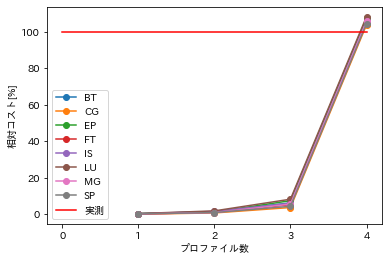

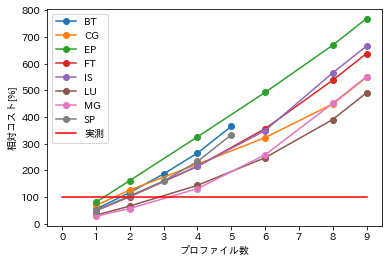

In [8]:
# 研究会で必要なグラフを生成する

# ipynb形式のライブラリのインポート
%run ./lib.ipynb

markers = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "*", "h", "H", "+", "x", "D", "d"]

def genGraphTimeRateProfiles(Fixed = "Process", Fix = 64, Predict = "D"):

    plt.figure()
    for benchmark in benchmarks:

        if(Fixed=="Process"):
            FixedDF = return_ErrorRateFixedProcess_AveragePredictCostRealCost(benchmark=benchmark, FixProcess=Fix, predict_class=Predict)
        else:
            FixedDF = return_ErrorRateFixedClass_AveragePredictCostRealCost(benchmark=benchmark, FixClass=Fix, predict_process=Predict)
        ConvertedIndexFixedDF = ConvertIndexNameToNumOfProfile(inputDF=FixedDF, Fixed=Fixed)
        x = ConvertedIndexFixedDF.index.tolist()
        y = ConvertedIndexFixedDF["PredictCosts"]
        RealCost = ConvertedIndexFixedDF["RealCost"]
        y_rate = y/RealCost * 100
        plt.plot(x,y_rate,marker="o", label=benchmark.upper())

    if(Fixed=="Process"):
        plt.plot([0,4],[100,100], color="r", label="実測")
        FileName = "FixProcessAllTime.pdf"
    else:
        plt.plot([0,9],[100,100], color="r", label="実測")
        FileName = "FixClassAllTime.pdf"
        
    plt.legend()
    plt.xlabel("プロファイル数")
    plt.ylabel("相対コスト[%]")
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.savefig(f"./tmp_GenerateResources/{FileName}")

genGraphTimeRateProfiles(Fixed = "Process", Fix = 64, Predict = "D")
genGraphTimeRateProfiles(Fixed = "Class",Fix = "B",Predict = 256)


In [9]:
# 問題サイズDに対する予測で、プロファイル数３の時の平均平均誤差率 < プロファイル数４の時の平均平均誤差率　となっているものを探す
Fixed="Process"
Fix=64
FixProcess=Fix
Predict="D"
predict_class=Predict
EnableTitle=False
SaveGraph=True
for benchmark in benchmarks:
    ErrorRateFixedProcess = return_ErrorRateFixedProcessAverageAndCosts(benchmark=benchmark, FixProcess=FixProcess, predict_class=predict_class)

    print(ErrorRateFixedProcess)

                        Average  PredictCosts
['A', 'B', 'C', 'D']     51.912      31604.48
['A', 'B', 'C']       35.667371       1852.16
['A', 'B']            35.628016        430.08
['A']                 36.060694         79.36
                         Average  PredictCosts
['A', 'B', 'C', 'D']   11.926136      14526.72
['A', 'B', 'C']        10.475864        513.92
['A', 'B']            253.014091         99.20
['A']                  28.185318          3.20
                     Average  PredictCosts
['A', 'B', 'C', 'D']     0.0       7335.04
['A', 'B', 'C']          0.0        507.52
['A', 'B']               0.0         81.28
['A']                    0.0         26.88
                         Average  PredictCosts
['A', 'B', 'C', 'D']   13.059577      10872.96
['A', 'B', 'C']        15.726654        541.44
['A', 'B']            912.363038        108.80
['A']                  28.298731          9.60
                       Average  PredictCosts
['A', 'B', 'C', 'D']  3.741429        65

In [10]:
for benchmark in benchmarks:
    ErrorRateFixedProcessDF = return_ErrorRateFixedProcessDF(benchmark=benchmark, FixProcess=FixProcess, predict_class=predict_class)
    ErrorRateFixedProcessDF.to_csv(f"./tmp_GenerateResources/ErrorRateFixedProcessDF_{benchmark}.csv")

In [11]:
for benchmark in benchmarks:
    FixProcessDF = return_FixedProcessModelDF(benchmark=benchmark, FixProcess=256)
    FixProcessDF.to_csv(f"./tmp_GenerateResources/FixedProcessModelDF_{benchmark}.csv")

bt
                                                      S    W    A    B    C  \
Name                                                                          
.TAU_application, MPBT, MPI_Comm_rank(), MPI_Co...  1.0  1.0  1.0  1.0  1.0   
MPI_Bcast()                                         1.0  1.0  1.0  1.0  6.0   

                                                      D  
Name                                                     
.TAU_application, MPBT, MPI_Comm_rank(), MPI_Co...  1.0  
MPI_Bcast()                                         1.0  


<Figure size 432x288 with 0 Axes>

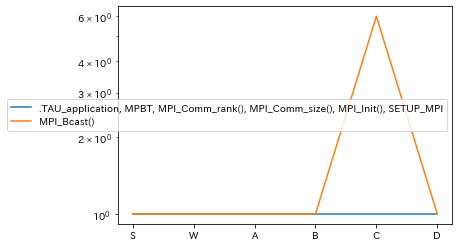

cg
                                                         A          B  \
Name                                                                    
.TAU_application, ALLOC_SPACE, CG, INITIALIZE_M...       1        1.0   
CONJ_GRAD                                               16       76.0   
ICNVRT                                              180347  1706010.0   
MPI_Irecv(), MPI_Send(), MPI_Wait()                   4208    19988.0   
SPRNVC, VECSET                                       14000    75000.0   

                                                            C           D  
Name                                                                       
.TAU_application, ALLOC_SPACE, CG, INITIALIZE_M...        1.0         1.0  
CONJ_GRAD                                                76.0       101.0  
ICNVRT                                              3936140.0  44047200.0  
MPI_Irecv(), MPI_Send(), MPI_Wait()                   19988.0     26563.0  
SPRNVC, VECSET               

<Figure size 432x288 with 0 Axes>

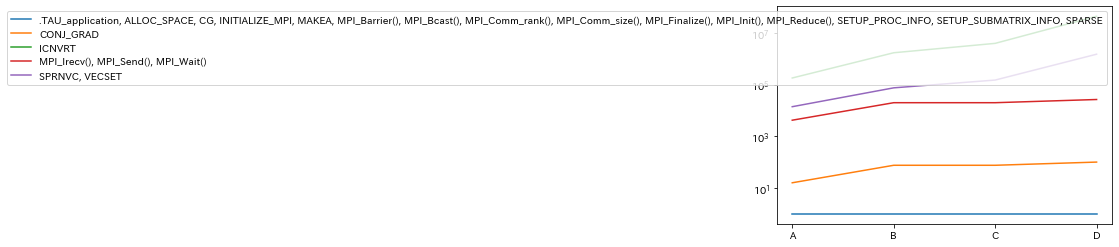

ep
                                                    A  B  C  D
Name                                                          
.TAU_application, EMBAR, MPI_Barrier(), MPI_Bca...  1  1  1  1
MPI_Allreduce()                                     4  4  4  4


<Figure size 432x288 with 0 Axes>

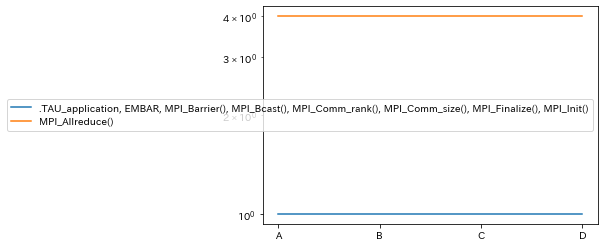

ft
                                                              A             B  \
Name                                                                            
.TAU_application, ALLOC_SPACE, FT, MPI_Barrier(...      1.00000       1.00000   
CFFTS1                                                 16.00000      44.00000   
CFFTS2, FFT, MPI_Alltoall(), TRANSPOSE2_FINISH,...      8.00000      22.00000   
CFFTZ                                                2048.00000   14080.00000   
CHECKSUM, EVOLVE, MPI_Reduce(), TRANSPOSE_X_YZ          6.00000      20.00000   
COMPUTE_INDEXMAP, COMPUTE_INITIAL_CONDITIONS, F...      2.00000       2.00000   
FFTZ2                                               15360.00000  115456.00000   
ILOG2                                                  26.00000      68.00000   
IPOW46                                                  4.00000       4.00000   
MPI_Bcast()                                             5.00000       5.00000   
SET_CLASS                

<Figure size 432x288 with 0 Axes>

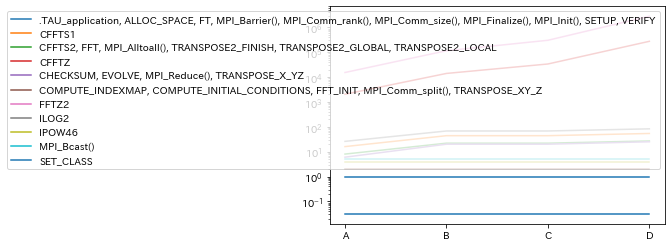

is
                                                               A  \
Name                                                               
.TAU_application, MPI_Bcast(), MPI_Comm_dup(), ...  1.000000e+00   
MPI_Allreduce(), MPI_Alltoall(), MPI_Alltoallv(...  1.100000e+01   
MPI_Irecv(), MPI_Wait()                             9.687500e-01   
MPI_Reduce()                                        2.000000e+00   
MPI_Send()                                          9.687500e-01   
double_randlc(double_*_double_*)                    1.048600e+06   

                                                               B  \
Name                                                               
.TAU_application, MPI_Bcast(), MPI_Comm_dup(), ...  1.000000e+00   
MPI_Allreduce(), MPI_Alltoall(), MPI_Alltoallv(...  1.100000e+01   
MPI_Irecv(), MPI_Wait()                             9.687500e-01   
MPI_Reduce()                                        2.000000e+00   
MPI_Send()                                  

<Figure size 432x288 with 0 Axes>

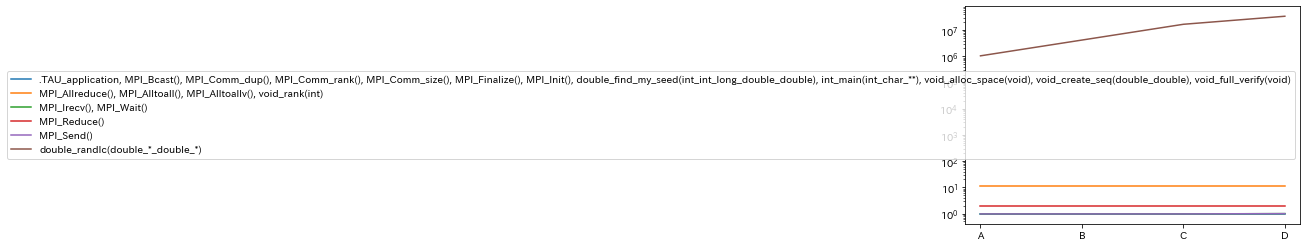

lu
                                                            A         B  \
Name                                                                      
.TAU_application, MPI_Comm_rank(), MPI_Comm_siz...   1.000000      1.00   
MPI_Allreduce()                                     11.000000     10.00   
MPI_Bcast()                                          1.000000     10.00   
MPI_Irecv(), MPI_Wait()                              0.996094    827.75   
MPI_Send()                                           0.996094  82402.80   

                                                            C          D  
Name                                                                      
.TAU_application, MPI_Comm_rank(), MPI_Comm_siz...       1.00       1.00  
MPI_Allreduce()                                         10.00      10.00  
MPI_Bcast()                                             10.00      10.00  
MPI_Irecv(), MPI_Wait()                                827.75     990.25  
MPI_Send()           

<Figure size 432x288 with 0 Axes>

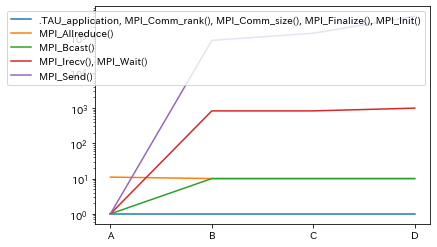

mg
                                                          A         B  \
Name                                                                    
.TAU_application, ALLOC_SPACE, MG_MPI, MPI_Comm...    1.000     1.000   
BUBBLE                                              468.125   468.125   
COMM3                                               119.000   487.000   
COMM3_EX, INTERP, RPRJ3                              35.000   147.000   
GIVE3, TAKE3                                        669.000  2733.000   
GIVE3_EX, TAKE3_EX                                   10.000    42.000   
MG3P                                                  5.000    21.000   
MPI_Allreduce()                                      88.000    88.000   
MPI_Barrier(), POWER                                  6.000     6.000   
MPI_Bcast()                                           7.000     7.000   
MPI_Irecv(), MPI_Send(), MPI_Wait(), READY          679.000  2775.000   
NORM2U3                                         

<Figure size 432x288 with 0 Axes>

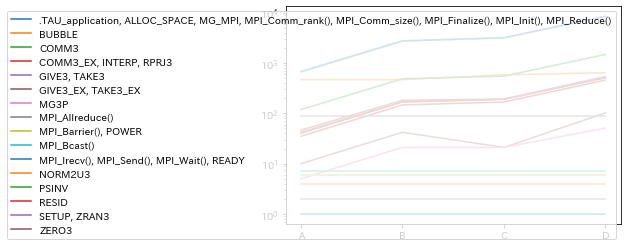

sp
                                                          A       C
Name                                                               
.TAU_application, ALLOC_SPACE, MPI_Comm_rank(),...     1.00     1.0
MPI_Allreduce()                                       88.00     2.0
MPI_Barrier()                                          6.00     2.0
MPI_Bcast()                                            7.00     4.0
MPI_Irecv()                                         2948.25  9630.0


<Figure size 432x288 with 0 Axes>

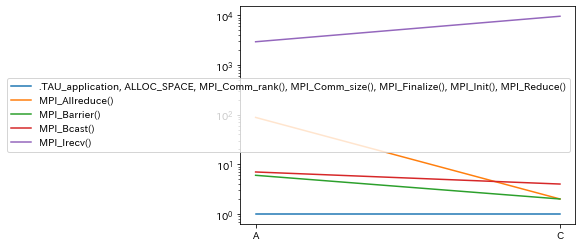

In [12]:
for benchmark in benchmarks:
    print(benchmark)
    FixProcessDF = return_summarized_Fixed_dataframe(BenchMark_name = benchmark, fixed="process")
    FixProcessDFwithoutNaN = FixProcessDF.dropna(how='any', axis=0)
    print(FixProcessDFwithoutNaN)
    indice = FixProcessDFwithoutNaN.T.index.tolist()
    columns = FixProcessDFwithoutNaN.T.columns.tolist()
    plt.figure()
    x = indice
    for column in columns:
        y = FixProcessDFwithoutNaN.loc[column]
        plt.plot(x, y, label=column)
    plt.yscale('log')
    plt.legend()
    plt.show()

bt
                                                    1    2    4    8    16   \
Name                                                                          
.TAU_application, MPBT, MPI_Comm_rank(), MPI_Co...  1.0  1.0  1.0  1.0  1.0   
MPI_Bcast()                                         6.0  1.0  6.0  1.0  6.0   

                                                    32   64   128  256  
Name                                                                    
.TAU_application, MPBT, MPI_Comm_rank(), MPI_Co...  1.0  1.0  1.0  1.0  
MPI_Bcast()                                         6.0  6.0  1.0  6.0  


<Figure size 432x288 with 0 Axes>

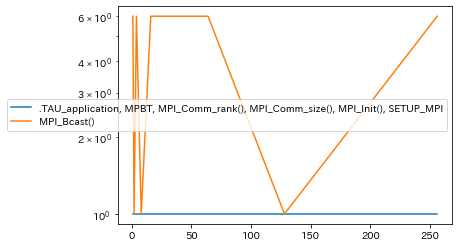

cg
                                                          1          2    \
Name                                                                       
.TAU_application, ALLOC_SPACE, CG, INITIALIZE_M...        1.0        1.0   
CONJ_GRAD                                                76.0       76.0   
ICNVRT                                              1984770.0  2263540.0   
MPI_Irecv(), MPI_Send(), MPI_Wait()                   12236.0    12483.0   
SPRNVC, VECSET                                        84375.0    93750.0   

                                                          4          8    \
Name                                                                       
.TAU_application, ALLOC_SPACE, CG, INITIALIZE_M...        1.0        1.0   
CONJ_GRAD                                                76.0       76.0   
ICNVRT                                              2821070.0  3936140.0   
MPI_Irecv(), MPI_Send(), MPI_Wait()                   10982.0    13984.0   
SPRNVC, 

<Figure size 432x288 with 0 Axes>

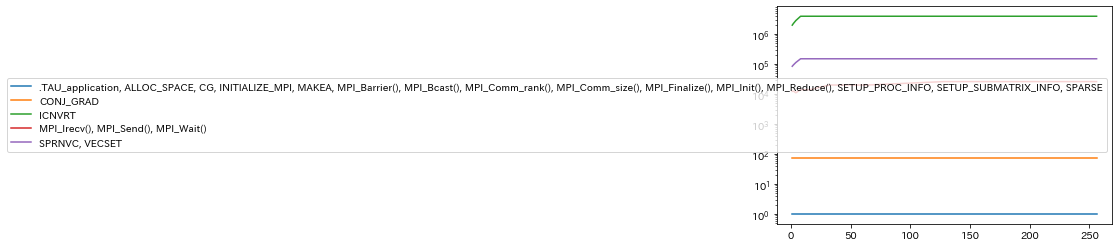

ep
                                                    1    2    4    8    16   \
Name                                                                          
.TAU_application, EMBAR, MPI_Barrier(), MPI_Bca...    1    1    1    1    1   
MPI_Allreduce()                                       4    4    4    4    4   

                                                    32   64   128  256  
Name                                                                    
.TAU_application, EMBAR, MPI_Barrier(), MPI_Bca...    1    1    1    1  
MPI_Allreduce()                                       4    4    4    4  


<Figure size 432x288 with 0 Axes>

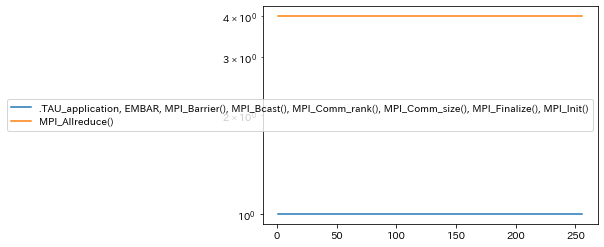

ft
                                                          1          2    \
Name                                                                       
.TAU_application, ALLOC_SPACE, FT, MPI_Barrier(...        1.0        1.0   
CFFTS1                                                   22.0       44.0   
CFFTS2, FFT                                              22.0       22.0   
CFFTZ                                               1081340.0   540672.0   
CHECKSUM, EVOLVE, MPI_Reduce()                           20.0       20.0   
COMPUTE_INDEXMAP, COMPUTE_INITIAL_CONDITIONS, F...        2.0        2.0   
FFTZ2                                               9732100.0  4866050.0   
ILOG2                                                    68.0       68.0   
IPOW46                                                    4.0        4.0   
MPI_Bcast()                                               5.0        5.0   
SET_CLASS                                                 1.0        0.5   

        

<Figure size 432x288 with 0 Axes>

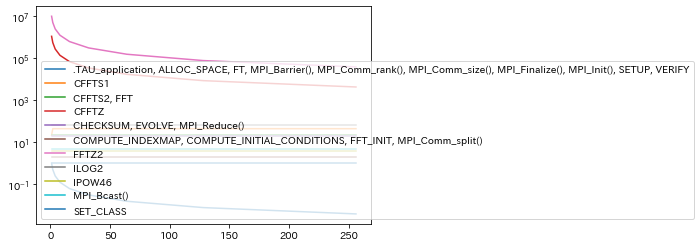

is
                                                            1            2    \
Name                                                                           
.TAU_application, MPI_Bcast(), MPI_Comm_dup(), ...          1.0          1.0   
MPI_Allreduce(), MPI_Alltoall(), MPI_Alltoallv(...         11.0         11.0   
MPI_Reduce()                                                2.0          2.0   
double_randlc(double_*_double_*)                    536871000.0  268435000.0   

                                                            4           8    \
Name                                                                          
.TAU_application, MPI_Bcast(), MPI_Comm_dup(), ...          1.0         1.0   
MPI_Allreduce(), MPI_Alltoall(), MPI_Alltoallv(...         11.0        11.0   
MPI_Reduce()                                                2.0         2.0   
double_randlc(double_*_double_*)                    134218000.0  67108900.0   

                                         

<Figure size 432x288 with 0 Axes>

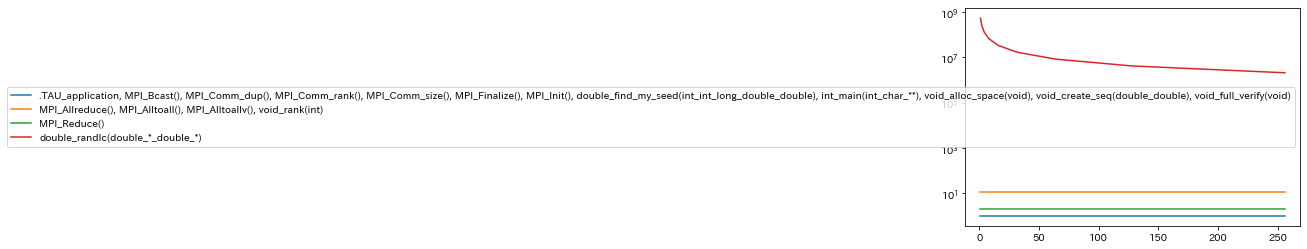

lu
                                                           1           2    \
Name                                                                         
.TAU_application, ALLOC_SPACE, APPLU, BCAST_INP...         1.0         1.0   
BLTS, BUTS, JACLD, JACU                              6425600.0   6425600.0   
EXACT                                               53562900.0  26781500.0   
EXCHANGE_1                                            160640.0    160640.0   
EXCHANGE_3                                               508.0       508.0   
EXCHANGE_5                                                 2.0         2.0   
EXCHANGE_6                                                 2.0         1.0   
L2NORM                                                     4.0         4.0   
MPI_Allreduce(), MPI_Bcast()                              10.0        10.0   
MPI_Barrier(), SETBV, SETIV, SSOR                          2.0         2.0   
RHS                                                      253.

<Figure size 432x288 with 0 Axes>

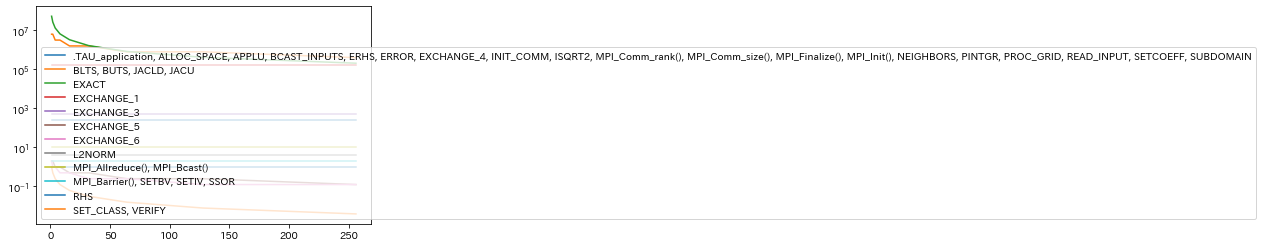

mg
                                                      1      2      4    \
Name                                                                      
.TAU_application, ALLOC_SPACE, MG_MPI, MPI_Comm...    1.0    1.0    1.0   
BUBBLE                                              666.0  647.0  632.5   
COMM3                                               550.0  550.0  550.0   
COMM3_EX, INTERP, RPRJ3                             168.0  168.0  168.0   
MG3P                                                 21.0   21.0   21.0   
MPI_Allreduce()                                      88.0   88.0   88.0   
MPI_Barrier(), POWER                                  6.0    6.0    6.0   
MPI_Bcast()                                           7.0    7.0    7.0   
NORM2U3                                               4.0    4.0    4.0   
PSINV                                               189.0  189.0  189.0   
RESID                                               191.0  191.0  191.0   
SETUP, ZRAN3          

<Figure size 432x288 with 0 Axes>

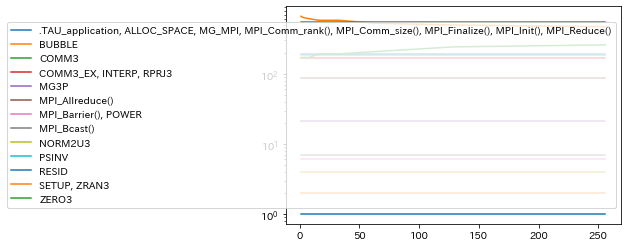

sp
                                                    1    2    4    8    16   \
Name                                                                          
.TAU_application, MPI_Comm_rank(), MPI_Comm_siz...  1.0  1.0  1.0  1.0  1.0   
MPI_Bcast()                                         4.0  1.0  4.0  1.0  4.0   

                                                    32   64   256  
Name                                                               
.TAU_application, MPI_Comm_rank(), MPI_Comm_siz...  1.0  1.0  1.0  
MPI_Bcast()                                         4.0  4.0  4.0  


<Figure size 432x288 with 0 Axes>

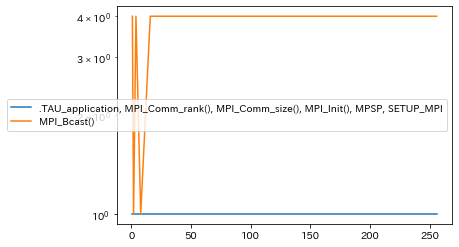

In [13]:
for benchmark in benchmarks:
    print(benchmark)
    FixProcessDF = return_summarized_Fixed_dataframe(BenchMark_name = benchmark, fixed="class")
    FixProcessDFwithoutNaN = FixProcessDF.dropna(how='any', axis=0)
    print(FixProcessDFwithoutNaN)
    indice = FixProcessDFwithoutNaN.T.index.tolist()
    columns = FixProcessDFwithoutNaN.T.columns.tolist()
    plt.figure()
    x = indice
    for column in columns:
        y = FixProcessDFwithoutNaN.loc[column]
        plt.plot(x, y, label=column)
    plt.yscale('log')
    plt.legend()
    plt.show()